# Lightcurve Fitting Documentation

Given the changes that were made to the process in the closing days of my thesis, I chose to write an entirely new version of this documentation notebook rather than updating the old one. The methods in this notebook should be taken as a guide for the steps I used for the final version of my thesis, which can be found in $\texttt{sn2020bpi lightcurve modeling.ipynb} $. Currently, this only covers up to plotting the lightcurve fit against the sample companion data from Michael.

Note: for some reason, I'm seeing underscores in \texttt{} as a hyphen, so be sure to use the actual variable names with the underscore and not a hyphen unless otherwise stated.

## Part 1: Libraries

First, I'll import the relevant .py files used to fit the lightcurves. I've added some additional documentation to the functions in these files, but let me know if there's anything unclear. I'll also explain more once I get into the actual data processing.

In [1]:
from useful_functions import *
from emceeHammer import *
np.random.seed(1006)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


$\texttt{useful_functions}$ is just a bunch of functions that I find, well, useful that I've compiled over time. This is just for convenience. It also imports all the usual modules (numpy, scipi, astropy, pandas, etc.). All packages I have installed are listed in the $\texttt{env.txt}$ file; note that a large number of these aren't really relevant to the project as I foolishly neglected to create an isolated environment. That being said, there shouldn't be any issues with using different versions as far as I'm aware; most of the functions I call are fairly common ones that haven't changed in a while, at least at the time of writing this. 

$\texttt{emceeHammer}$ is where the actually important things for the lightcurve fitting are located. I've added further documentation to these functions, but I'll also elaborate on their usage later. 

## Part 2: Data

While there were a number of different versions of the 2020bpi data, I ultimately ended up using a normalized version of the raw updated data. Sector 21 of the data had no changes between versions, but I used this new version for consistency. The original files from Michael can be found in the $\texttt{Fausnaugh}$ and $\texttt{Fausnaugh_Updated}$ folders in the root directory.

In [2]:
tess2020bpi = pd.read_csv('./JhaData/TESS_SN2020bpi_s21_a_MCMC.csv')
tess2020bpi

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_raw_flux,flux,e_flux,scale,shift,bkg_frac
0,1870.44408,58869.94408,-5339.0302,1368.8706,0.009095,-0.032976,0.008455,-0.002273,0.006981,0.825751,0.036886,1.311607
1,1870.46491,58869.96491,-6841.1413,1375.3282,0.009095,-0.042254,0.008495,-0.009934,0.007014,0.825751,0.036886,1.311607
2,1870.48574,58869.98574,-2219.7583,1400.7610,0.009095,-0.013710,0.008652,0.013636,0.007144,0.825751,0.036886,1.311607
3,1870.50658,58870.00658,-10843.6913,1370.6601,0.009095,-0.066975,0.008466,-0.030347,0.006991,0.825751,0.036886,1.311607
4,1870.52741,58870.02741,-9069.4821,1365.9754,0.009095,-0.056017,0.008437,-0.021299,0.006967,0.825751,0.036886,1.311607
...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1897.67205,58897.17205,9985.5409,1085.6790,0.010174,0.061675,0.006706,0.074470,0.005537,0.825751,0.036886,1.311607
1258,1897.69288,58897.19288,12474.4539,1076.9029,0.010174,0.077047,0.006651,0.087164,0.005492,0.825751,0.036886,1.311607
1259,1897.71372,58897.21372,13437.6431,1074.2548,0.010247,0.082996,0.006635,0.091980,0.005479,0.825751,0.036886,1.311607
1260,1897.73455,58897.23455,7001.0698,1082.1323,0.010174,0.043241,0.006684,0.059249,0.005519,0.825751,0.036886,1.311607


This is the TESS data for only sector 21 of 2020bpi. I made a few additions to the original version of the data, but a number of these columns aren't used for the lightcurve fitting. I'll define each of the columns here:

- $\texttt{BTJD}$: Barycentric TESS Julian Date (BJD-2457000.0). This is the original time format for the data.
- $\texttt{mjd}$: Conversion from BTJD to MJD using astropy.
- $\texttt{cts}$: electron counts; this is the original quantity provided by Michael
- $\texttt{e_cts}$: the error of electron counts as originally provided by Michael.
- $\texttt{bkg_model}$: This is a slightly misleading column name; Michael provided the background model (an estimate of additional background light that could be subtracted) as counts, but this is actually the background model converted to flux, which I explain for the next data column.
- $\texttt{raw_flux}$: This is a conversion from the original counts to flux in units of counts per second per square centimeter: 
\begin{equation}\label{eq:fluxEq}
\frac{counts}{T_{TESS} A_{TESS}}
\end{equation}
I took the average exposure time to be $2010.8$ seconds (just over half an hour) and the detector area to be $86.6 \ \text{cm}^2$. I believe Michael's paper provides companion flux in units of electron counts per second, which I later accounted for. It's called "raw" in that I never applied any adjustments to this data; if you recall, I spent a fair deal of time fitting the TESS lightcurve to the ZTF lightcurve. This ultimately proved troublesome for the fit (I haven't been able to figure out why unfortunately), so I ended up using the "raw" values for the analysis.
- $\texttt{e_raw_flux}$: The counts error converted in the same way as the counts.

Those are the important columns that were actually used for the analysis in my thesis (excluding $\texttt{bkg_model}$). The other columns are a result of my attempts to fit the TESS lightcurve to the ZTF lightcurve and were abandoned for the final analysis. You can ignore the other columns for the most part, but I'll still define them

- $\texttt{flux}$: the scaled and shifted flux values with a fraction of additional background subtracted.
- $\texttt{e_flux}$: the scaled flux error (no shift or additional background subtraction).

The last three are the optimal values found with MCMC for minimizing the difference between the ZTF and TESS lightcurves and are the parameters to convert $\texttt{raw_flux}$ to $\texttt{flux}$. They can also be ignored.  
- $\texttt{scale}$: The scale factor to apply to the flux to match it to the ZTF lightcurve.
- $\texttt{shift}$: The vertical shift to apply to the flux to match it to the ZTF lightcurve.
- $\texttt{bkg_frac}$: The fraction of $\texttt{bkg_model}$ to subtract from the flux to match it to the ZTF lightcurve.

In [3]:
tess2020bpiNorm = normLC(tess2020bpi)
tess2020bpiNorm = tess2020bpiNorm[tess2020bpiNorm.mjd_0 >0.5].copy()
tess2020bpiNorm['raw_flux'] = tess2020bpiNorm['raw_flux'] + 0.313
tess2020bpiNorm

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_raw_flux,flux,e_flux,scale,shift,bkg_frac,mjd_0
25,1870.96488,58870.46488,-7424.3992,1223.1407,0.003404,-0.060932,0.061604,-0.044396,0.050869,0.825751,0.036886,1.311607,0.52080
26,1870.98571,58870.48571,-8717.5175,1146.6403,0.003404,-0.126060,0.057751,-0.098176,0.047688,0.825751,0.036886,1.311607,0.54163
27,1871.00655,58870.50655,-8900.9508,1186.4059,0.003404,-0.135299,0.059754,-0.105805,0.049342,0.825751,0.036886,1.311607,0.56247
28,1871.02738,58870.52738,-7685.3109,1173.8512,0.003404,-0.074073,0.059121,-0.055248,0.048819,0.825751,0.036886,1.311607,0.58330
29,1871.04821,58870.54821,-8359.4403,1190.6748,0.002610,-0.108025,0.059969,-0.074786,0.049519,0.825751,0.036886,1.311607,0.60413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1897.67205,58897.17205,9985.5409,1085.6790,0.010174,0.815924,0.054681,0.607263,0.045152,0.825751,0.036886,1.311607,27.22797
1258,1897.69288,58897.19288,12474.4539,1076.9029,0.010174,0.941279,0.054239,0.710775,0.044787,0.825751,0.036886,1.311607,27.24880
1259,1897.71372,58897.21372,13437.6431,1074.2548,0.010247,0.989790,0.054105,0.750050,0.044677,0.825751,0.036886,1.311607,27.26964
1260,1897.73455,58897.23455,7001.0698,1082.1323,0.010174,0.665611,0.054502,0.483141,0.045005,0.825751,0.036886,1.311607,27.29047


The columns are the same as above with the exception of the additional $\texttt{mjd_0}$ column

- $\texttt{mjd_0}$: this is the $\texttt{mjd}$ value with the first value as the zero-point. This was convenient for the MCMC fitting because using $\texttt{mjd}$ as the value for time would make the exponential function very sensitive to small changes.

The first 12 hours of sector 21 data is excluded as it seems to still suffer from excess earthshine and would negatively affect the lightcurve fit.

I've also normalized the flux values to roughly 40% of the peak flux as measured from the original version of the data from Michael. Because some of the counts are negative, there are also negative flux values. I apply a slight corrective shift that I found through trial and error to get the pre-explosion flux close to zero; there is a parameter in the emcee that accounts for the uncertainty of this adjustment.

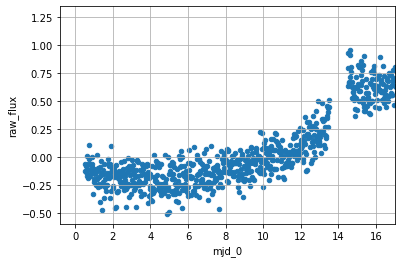

In [4]:
ax = tess2020bpiNorm.plot('mjd_0','raw_flux',kind='scatter');
ax.grid();
ax.set_xlim(right=17);

## Part 3: Lightcurve Fitting

From here, the lightcurve is fit to a parametrized model using emcee. This is when the functions in $\texttt{emceeHammer.py}$ (besides $\texttt{normlc}()$) are used. I'll briefly break down each of the main functions here: 

- $\texttt{get_fullparam}$(): Called in most of the other functions; it takes the provided guess/scale dictionaries and adds default values for the other parameters. This provides two convenient features; by using a keyed dictionary, you don't have to worry about making sure the values you provide are in the correct order. This also allows one to hold a given parameter to a constant value by excluding it from the guess/scale dictionaries. This function also allows the other functions to interpret the parameter dictionaries even though emcee doesn't natively pass dictionaries (this is why it has the semi-redundant argument). The default values for the parameters can be altered in this function, but be careful to ensure they don't violate any of the prior conditions.

- $\texttt{lc_model}$(): Used to find the variance and flux for a given model with the parameter values provided by emcee. For the purposes of my thesis, you can ignore pretty much all of the curve models besides 'dcRaw'. There's a few non-functioning models that I had been working on, but those are indicated in the code. This function makes use of the dictionary to call parameters and also conditional list comprehensions to hold the flux to some constant until the time of explosion. Additional models can be added by adding an additional conditional.

- $\texttt{log_prior}$(): Establishes all dissallowed parameter values. In the current implementation, there are only hard limits, but there were previously some soft limits that worked. As said before, ensure these agree with default values of parameters or else emcee will get stuck.

- $\texttt{log_likelihood}$(): Calculates the log of the likelihood of the fit for a given set of parameter values. Note that the conditionals are just a result of the way the data is formatted; if you alter the naming scheme for the pandas DataFrame, this would be affected.

- $\texttt{log_posterior}$(): Returns the sum of the previous two functions. If the debug parameter is set to True, it will only return the value from $\texttt{log_prior}$() to determine if there's any issues with the priors.

- $\texttt{doMCMC}$(): Runs emcee for the given model and parameters and optionally makes and saves a corner plot (saved as a pdf by default). Most of the previous functions are called when running the emcee fit.

- $\texttt{hammerTime}$(): Calls the previous function and reformats the data so it can be returned in a more manageable and informative DataFrame. This function will also plot the median fit as well as a selection of random fits against the actual data points and also plots the residual (saved as a pdf by default). Function returns two DataFrames - the first ('fitPD') contains all the parameter combinations tried when fitting the model and the second ('modelPD') is a version of the lightcurve DataFrame with the flux of the median model and its residuals. When the savePlots argument is True, these will also be saved as seperate csv files. the format of naming scheme can be changed by altering the fileName and dirString variables.

Most of the functions have arguments with defaults matching my analysis, so there's only a few mandatory arguments. The functions themselves have documentation for the specifics of their arguments.

From here, the only function that really needs to be called is $\texttt{hammerTime}$(), which I do below. Here, the "guess" variable is just the initial guess for each of the parameters, and the "scale" is how large each step emcee should take when varying the values.

sampling...



done


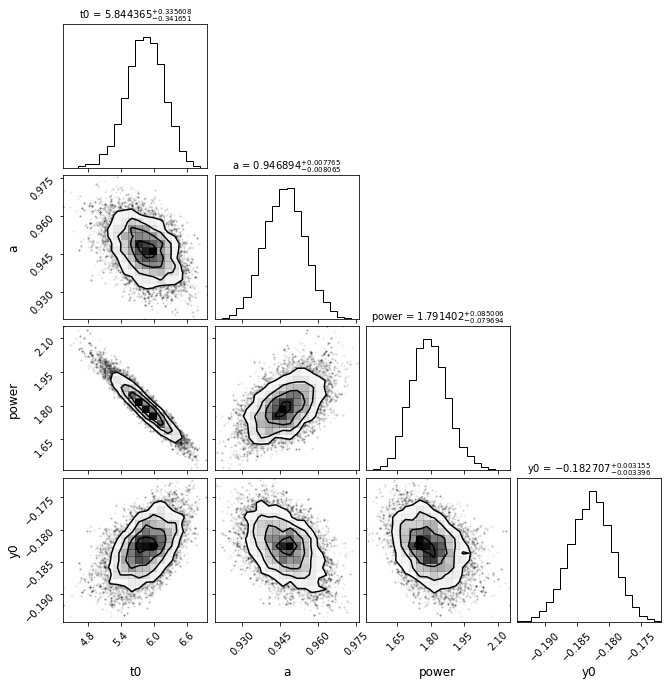

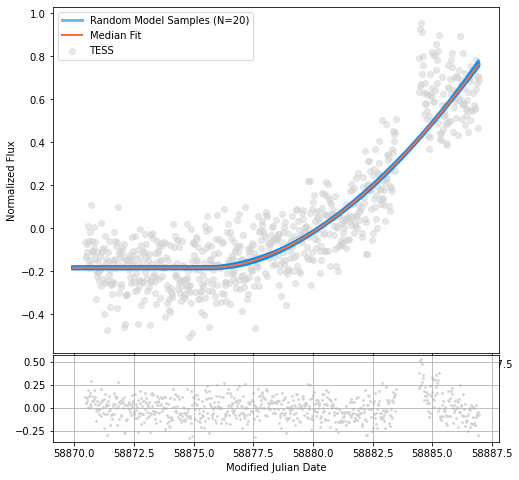

In [5]:
guess = {'t0':5.86, 'a':0.94,'power':1.79,'y0':-0.01} 
scale = {'t0':0.1, 'a':0.1,'power':0.1,'y0':0.01}

fitParameters, fitCurve = hammerTime(tess2020bpiNorm, guess, scale,
                                     cutoff=17, nwalkers=10, nburn=250, nsteps=2250,
                                     curveModel='dcRaw', savePlots=False,
                                     plotPal=('lightgrey','#008DF9','#FF6E3A')
                                    );

In this case, I didn't save the plot, but if savePlots is True, the plots will be saved to the directory designated in emceeHammer by the dirString variable. The names of the plots and csv files can be a bit long because I included information about the specific run, so you could probably just modify these for simplicity in the hammerTime and doMCMC functions.

# Part 4: Companion Analysis

I unfortunately didn't get to analyze the companion emission in as much depth as I would have like to, but I'll recount the work I was able to do here.

The companion emission from the paper is flux in electrons per second at a distance of 100 Mpc; sn2020bpi is 174.2 Mpc away. To account for this, I calculate the luminosity distance

In [7]:
compFluxRaw = pd.read_csv('CompanionEmission(Reformat).csv')
display(compFluxRaw)

tess_area = np.pi * 5.25**2
compFlux = pd.DataFrame()
compRads = ['f50','f25','f10','f5','f1','f0.5','f0.1']
fluxNorm = 0.12263194790077989 ##same normalization factor used for TESS data
compFlux['t-t0'] = compFluxRaw['time']
for rad in compRads:
    compFlux[rad] = ((compFluxRaw[rad]/tess_area)*((100**2)/(174.2)**2))/(fluxNorm)
display(compFlux)

,time,f50,m50,f25,m25,f10,m10,f5,m5,f1,m1,f0.5,m0.5,f0.1,m0.1
0,0.001023,0.006878,25.8464,0.005772,26.0367,0.004573,26.2895,0.003825,26.4835,0.002537,26.9293,0.002121,27.1239,0.001392,27.5807
1,0.022361,0.163347,22.4072,0.135896,22.6070,0.106148,22.8752,0.087604,23.0837,0.055745,23.5745,0.045491,23.7952,0.027665,24.3352
2,0.043699,0.320540,21.6753,0.265446,21.8801,0.205781,22.1565,0.168622,22.3727,0.104925,22.8878,0.084504,23.1228,0.049251,23.7090
3,0.065037,0.476072,21.2458,0.392814,21.4545,0.302707,21.7374,0.246644,21.9598,0.150757,22.4943,0.120139,22.7408,0.067651,23.3643
4,0.086375,0.629687,20.9422,0.517945,21.1543,0.397088,21.4428,0.321967,21.6705,0.193776,22.2217,0.153006,22.4782,0.083604,23.1344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,16.281848,21.303393,17.1189,11.464799,17.7916,4.334410,18.8477,1.790086,19.8078,0.132666,22.6331,0.031510,24.1939,0.000427,28.8646
764,16.303186,21.299008,17.1191,11.458494,17.7922,4.329609,18.8489,1.787183,19.8096,0.132250,22.6365,0.031385,24.1982,0.000424,28.8717
765,16.324524,21.294604,17.1193,11.452184,17.7928,4.324812,18.8501,1.784284,19.8113,0.131835,22.6399,0.031260,24.2025,0.000421,28.8787
766,16.345862,21.290181,17.1196,11.445869,17.7934,4.320019,18.8513,1.781390,19.8131,0.131422,22.6433,0.031136,24.2068,0.000418,28.8858


,t-t0,f50,f25,f10,f5,f1,f0.5,f0.1
0,0.001023,0.000213,0.000179,0.000142,0.000119,0.000079,0.000066,0.000043
1,0.022361,0.005069,0.004217,0.003294,0.002719,0.001730,0.001412,0.000859
2,0.043699,0.009947,0.008238,0.006386,0.005233,0.003256,0.002622,0.001528
3,0.065037,0.014774,0.012190,0.009394,0.007654,0.004679,0.003728,0.002099
4,0.086375,0.019541,0.016074,0.012323,0.009992,0.006014,0.004748,0.002595
...,...,...,...,...,...,...,...,...
763,16.281848,0.661120,0.355794,0.134512,0.055553,0.004117,0.000978,0.000013
764,16.303186,0.660984,0.355598,0.134363,0.055463,0.004104,0.000974,0.000013
765,16.324524,0.660847,0.355402,0.134214,0.055373,0.004091,0.000970,0.000013
766,16.345862,0.660710,0.355206,0.134066,0.055283,0.004078,0.000966,0.000013


The time corresponds to number of days after the SN explosion, and the fluxes each correspond to the companion emission for companions of a given solar radius

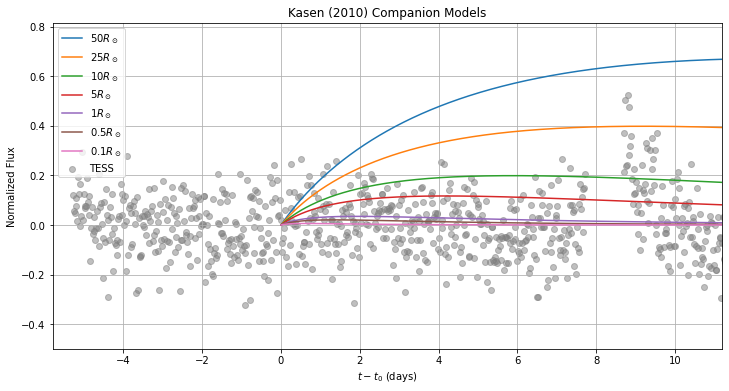

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
compFlux.plot('t-t0','f50',label=r'$50 R_\odot$',ax=ax)
compFlux.plot('t-t0','f25',ax=ax,label=r'$25 R_\odot$')
compFlux.plot('t-t0','f10',ax=ax,label=r'$10 R_\odot$')
compFlux.plot('t-t0','f5',ax=ax,label=r'$5 R_\odot$')
compFlux.plot('t-t0','f1',ax=ax,label=r'$1 R_\odot$')
compFlux.plot('t-t0','f0.5',ax=ax,label=r'$0.5 R_\odot$')
compFlux.plot('t-t0','f0.1',ax=ax,label=r'$0.1 R_\odot$')
ax.set_xlabel(r'$t-t_0$ (days)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Kasen (2010) Companion Models');
ax.grid();
ax.scatter(fitCurve.mjd_0-5.8, #5.8 is roughly the time of explosion with mjd_0
           fitCurve.modelResidual, ls='None',
           color='grey',alpha=0.5,label='TESS')
ax.legend()
ax.set_xlim(left=-5.8,right=17-5.8);
ax.set_ylim(bottom=-0.5);

My apologies if anything is unclear; I realize I made some obtuse coding choices at points. Let me know if there's anything that needs clarification or adjustment!